In [1]:
from neo4j import GraphDatabase

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker

import pandas as pd

import networkx as nx
import numpy as np

from dotenv import load_dotenv

import json, random, statistics, os, collections, pylab

load_dotenv("../.env")

True

In [2]:
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_NAME = os.getenv("NEO4J_NAME")
NEO4J_PASS = os.getenv("NEO4J_PASS")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_NAME, NEO4J_PASS))

In [3]:
# get graph
with driver.session() as session:
  res = session.run("MATCH (n)-[r:RETWEETED]-(m) RETURN n, r, m")
  g = nx.Graph()

  nodes = list(res.graph()._nodes.values())
  for node in nodes:
    node_kind = list(node._labels)[0] # converting frozenset to list, then taking the only value (tweet/author)
    g.add_node(node.id, labels=node._labels, properties=node._properties, kind = node_kind)

  rels = list(res.graph()._relationships.values())
  for rel in rels:
    g.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)

/tmp/ipykernel_312111/1301313705.py:9: DeprecationWarning: `id` is deprecated, use `element_id` instead
  g.add_node(node.id, labels=node._labels, properties=node._properties, kind = node_kind)
/tmp/ipykernel_312111/1301313705.py:13: DeprecationWarning: `id` is deprecated, use `element_id` instead
  g.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)


In [4]:
# removing self loops
g.remove_edges_from(nx.selfloop_edges(g))

# prune disconnected nodes
relevant_graph = g.subgraph(max(nx.connected_components(g), key=len))

print(relevant_graph)

Graph with 14439 nodes and 16531 edges


In [5]:
pos = nx.spring_layout(relevant_graph)

In [6]:
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]

    return rgb_colors

In [7]:
communities = nx.community.louvain_communities(relevant_graph)
print(f"communities: {len(communities)}")

node_community_dict = {}
for i, community in enumerate(communities):
    for node in community:
        node_community_dict[node] = i

communities: 76


## aplicação direta louvain

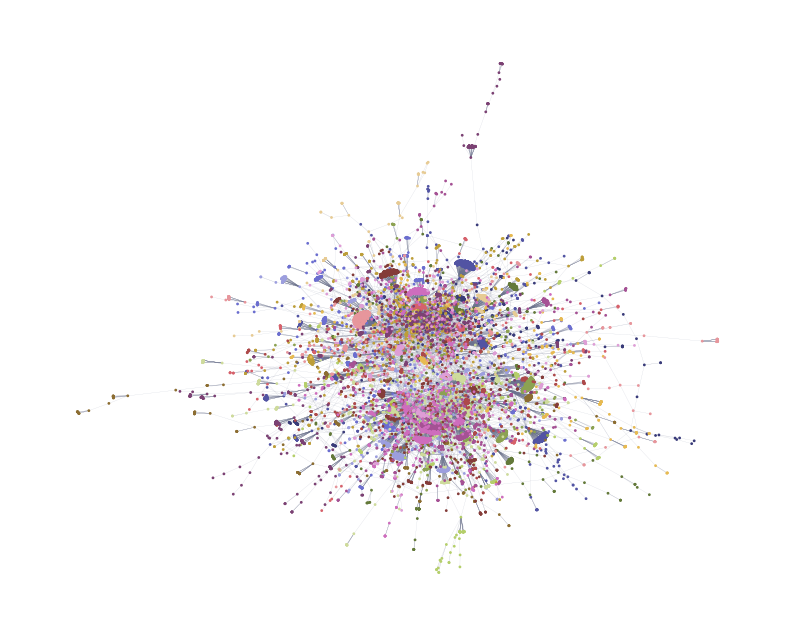

In [8]:
cmap = cm.get_cmap('tab20b', len(communities) + 1)

fig = plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw_networkx_nodes(
  relevant_graph, pos, node_community_dict.keys(), node_size=1,
  cmap=cmap, node_color=list(node_community_dict.values())
)
nx.draw_networkx_edges(relevant_graph, pos, alpha=0.5, edge_color="#6B728E", width=0.1)
# plt.savefig("graph.png", dpi=1000)


## estatísticas conexões de usuários

[13931   203    68    64    31    17    22    11    13     8     6     9
     8     5     4     3     3     0     4     1     3     0     3     2
     1     2     0     0     1     0     0     0     0     0     0     0
     1     1     1     0     0     0     3     0     0     0     1     1
     0     2     1     0     0     0     0     0     0     0     1     0
     0     0     0     0     1     0     0     0     0     0     0     0
     0     0     0     1     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     1]


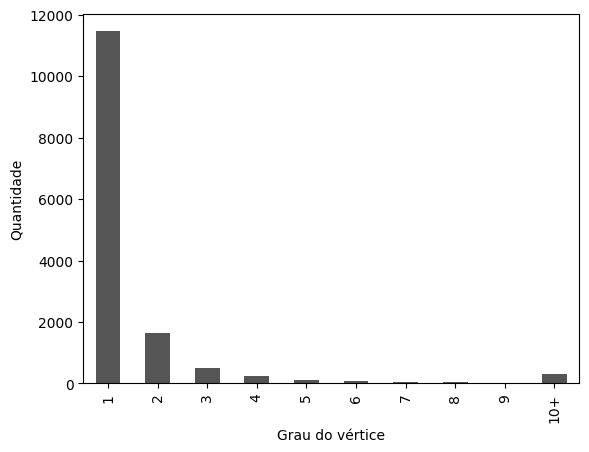

In [9]:
degree_data = dict(relevant_graph.degree())
degree_df = { "id": degree_data.keys(), "degree": degree_data.values() }
hist = np.histogram(list(degree_data.values()), 100)
print(hist[0])
# print(hist[1])

df = pd.DataFrame(degree_df)
degree_count = df.groupby(by="degree").count().reset_index()
degree_count.rename(columns={ "id": "count"}, inplace=True)
degree_count["count"][9] = degree_count["count"][9:-1].sum()
degree_count["degree"][9] = "10+"
degree_count.drop(degree_count.index[9:-1])

ax = degree_count[0:10].plot.bar(x="degree", y="count", color="#555555")
ax.get_legend().remove()
plt.xlabel("Grau do vértice")
plt.ylabel("Quantidade")

plt.show()

## comunidades

In [10]:
centrality = nx.pagerank(relevant_graph)

def detect_outlier(data):
    outliers=[]
    threshold = 3
    mean = np.mean(data)
    std  = np.std(data)
    
    for y in data:
        z_score = (y - mean) / std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

median = statistics.median(list(centrality.values()))
print(f"median: {median}")

outliers = detect_outlier(list(centrality.values()))
filtered_outliers = [o for o in outliers if o > median]

print(f"Outliers: {sorted(filtered_outliers, reverse=True)}")

median: 3.49824656797909e-05
Outliers: [0.014446408229422088, 0.010770235160181121, 0.00965470427451132, 0.009628906241952192, 0.008317166431324309, 0.00755654292701914, 0.006479159008580415, 0.006364183374447413, 0.006357012101186051, 0.006207065878447195, 0.0059872125167950065, 0.005908143446932464, 0.00552135788530546, 0.005308833283900948, 0.0049923323106644945, 0.004893215308055635, 0.003754768859492688, 0.003702094214964956, 0.003652378227724354, 0.003541376481723623, 0.0030928446020285095, 0.003036123467874768, 0.003033430198307239, 0.0028972177901873245, 0.0028413842547762975, 0.002838939208465885, 0.0028384232965601914, 0.002837545735259862, 0.002688056607665063, 0.0025986033714743865, 0.0025510681678841424, 0.0023968884387181363, 0.002263597950061465, 0.0022254206729200683, 0.0022136795694758632, 0.0021855532761618736, 0.002175003812517542, 0.002132561163877328, 0.002068631226502048, 0.002063173970919829, 0.002046724146863007, 0.0020410134453377627, 0.002031898196464031, 0.00

In [11]:
# creates a 'supernode graph', consisting of top influencers
supernode_graph = relevant_graph.copy()
print(f"relevant graph size: {len(relevant_graph.nodes)}")

# supernode_graph.remove_edges_from(nx.selfloop_edges(supernode_graph))

keep_nodes = [k for k, v in centrality.items() if v >= filtered_outliers[-1]]
nodes_to_remove = [n for n in supernode_graph.nodes if n not in keep_nodes]

for node in nodes_to_remove:
  supernode_graph.remove_node(node)
print(f"supernode graph size: {len(supernode_graph.nodes)}")



relevant graph size: 14439
supernode graph size: 70


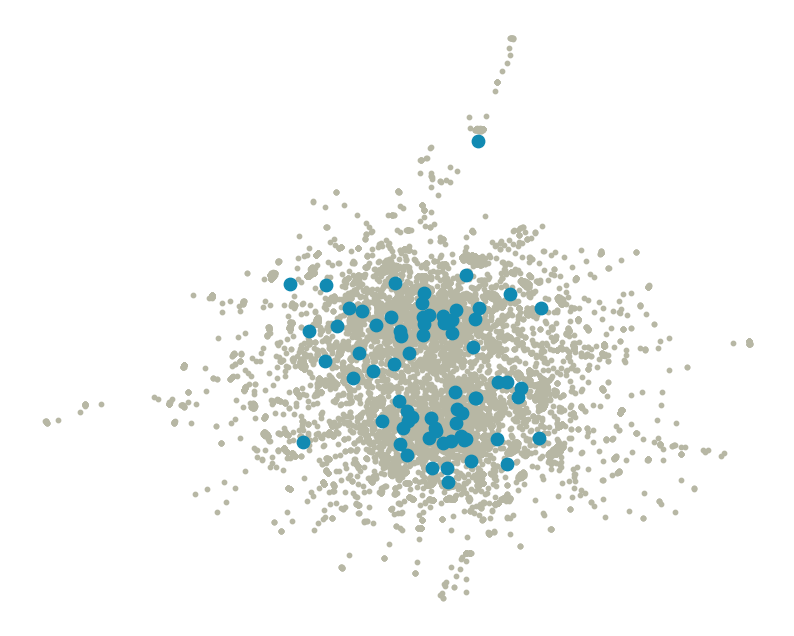

In [12]:
plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw_networkx_nodes(relevant_graph, pos, node_size=10, node_color="#b7b7a4")
nx.draw_networkx_nodes(supernode_graph, pos, node_size=80, node_color="#118ab2")

In [13]:
# create weighted edges for supernode graph.
# edge weight inversely proportional to path between nodes
for n in supernode_graph.nodes:
  for m in supernode_graph.nodes:
    if n == m: continue
    
    path_lenght = nx.algorithms.shortest_path_length(relevant_graph, source=n, target=m)
    weight = 1 / path_lenght
    
    supernode_graph.add_weighted_edges_from([(n, m, weight)])


# calculate communities for subgraph
communities = nx.community.louvain_communities(supernode_graph)
print(f"communities: {len(communities)}")

node_community_dict = {}
for i, community in enumerate(communities):
  for node in community:
    node_community_dict[node] = i

# add removed nodes to their closest super's community
for node in relevant_graph:
  path_lengths = {}
  for supernode in supernode_graph:
    if node == supernode: continue

    path_lengths[supernode] = nx.algorithms.shortest_path_length(relevant_graph, source=node, target=supernode)

  influencer_supernode = min(path_lengths, key=path_lengths.get)
  if influencer_supernode is None: continue
  
  node_community_dict[node] = node_community_dict[influencer_supernode]

communities: 2


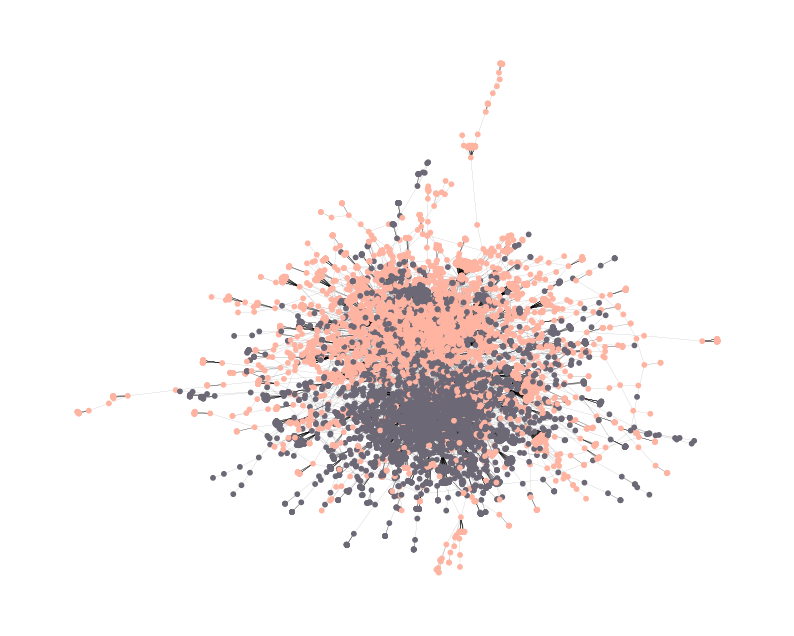

In [14]:
centrality_palette = get_color_gradient("#ffb4a2", "#6d6875", len(communities))
cmap = mcolors.LinearSegmentedColormap.from_list("palette", centrality_palette)

# cmap = cm.get_cmap('viridis', len(communities) + 1)

plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw_networkx_nodes(
  relevant_graph, pos, node_community_dict.keys(), node_size=10,
  cmap=cmap, node_color=list(node_community_dict.values())
)
nx.draw_networkx_edges(relevant_graph, pos, alpha=0.5, width=0.1)

## position calc with different iterations

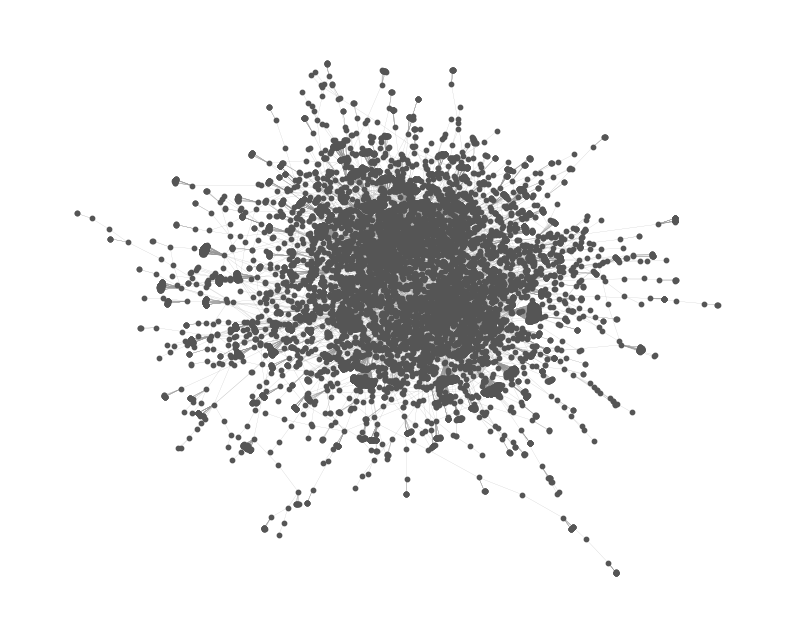

In [15]:
pos = nx.spring_layout(relevant_graph)
plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw(relevant_graph, pos, node_size=10, node_color="#555555", edge_color="#989898", width=0.1)

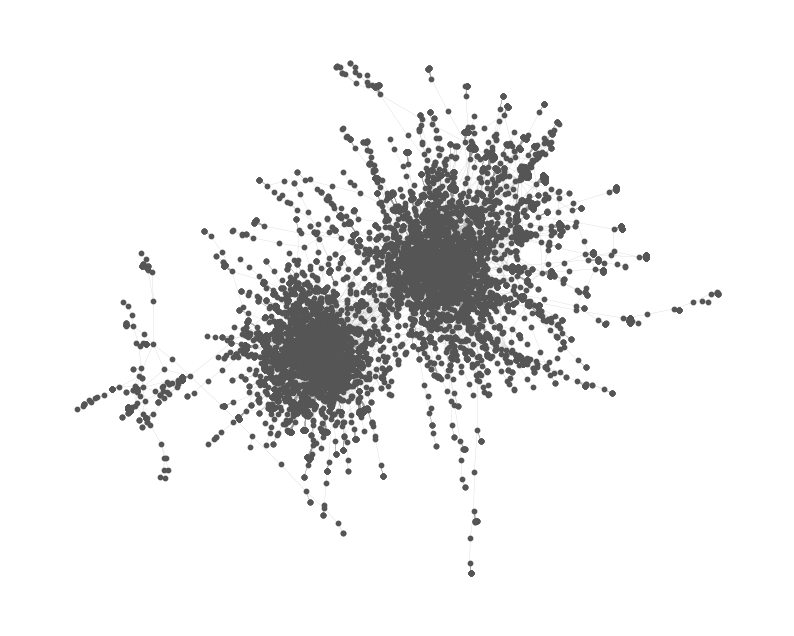

In [17]:
pos = nx.spring_layout(relevant_graph, iterations=200)
plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw(relevant_graph, pos, node_size=10, node_color="#555555", edge_color="#989898", width=0.1)

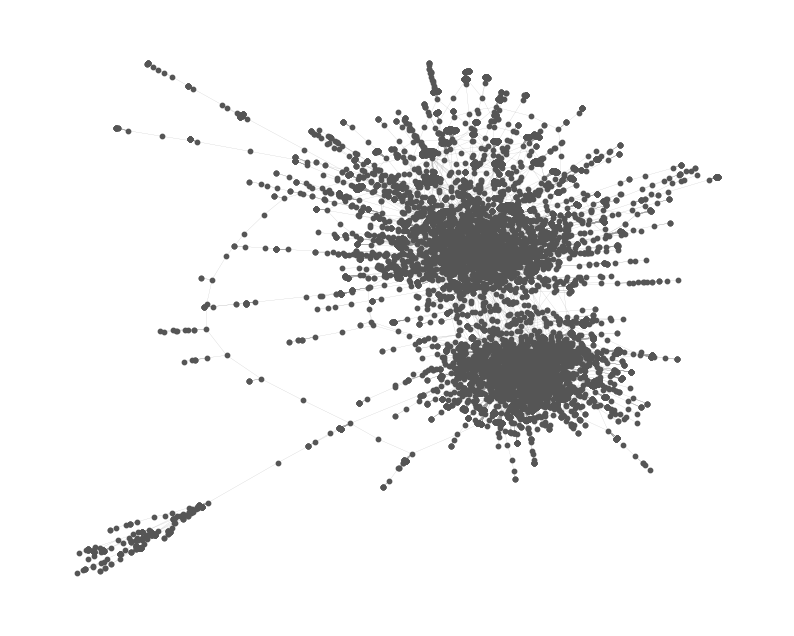

In [ ]:
pos = nx.spring_layout(relevant_graph, iterations=1000)
plt.figure(1, figsize=(10, 8))
plt.axis("off")
nx.draw(relevant_graph, pos, node_size=10, node_color="#555555", edge_color="#989898", width=0.1)